In [210]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
device = torch.device('cpu')

In [211]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms as T
from pathlib import Path

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(12, 12))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


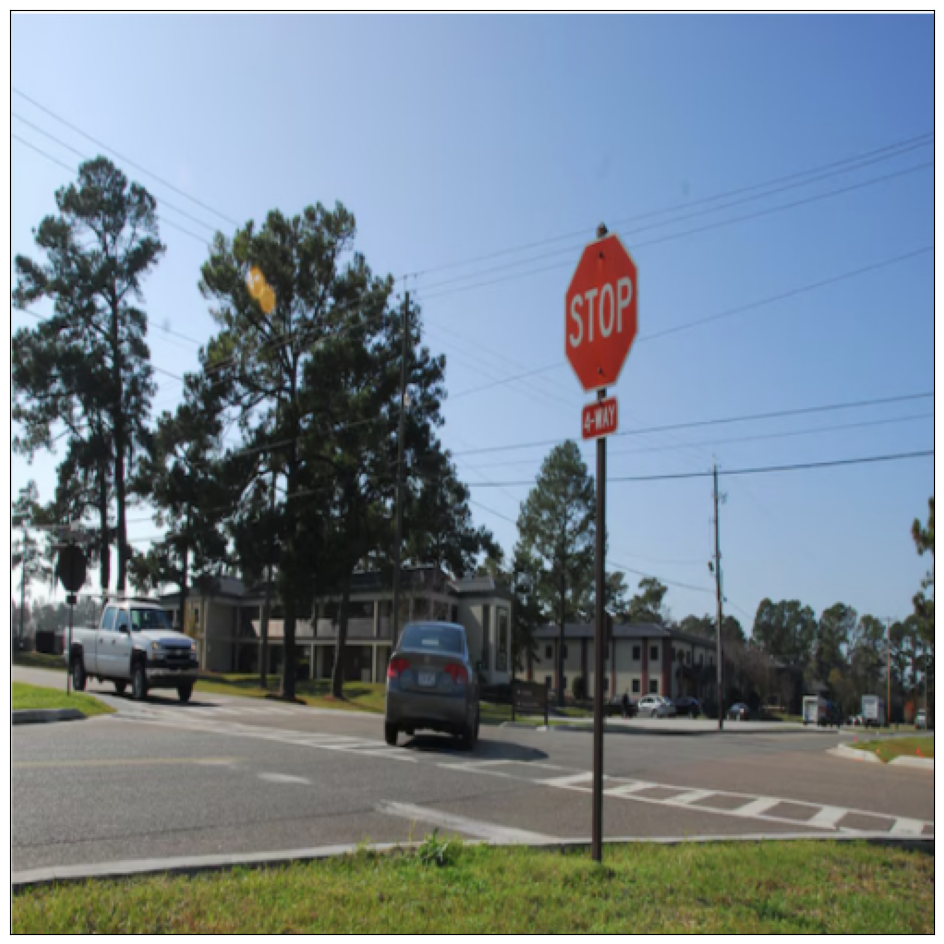

In [212]:
image_1 = read_image(str(Path('./stop.jpg')))
image_list = [T.Resize(size=(500,500))(image_1)]
grid = make_grid(image_list) # return a tensor containing a grid of images
show(grid)

In [213]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights, progress=False).to(device)
model = model.eval()

In [214]:
transforms = weights.transforms()
images = [transforms(image).to(device) for image in image_list]
for image in images:
  print(image.shape)

torch.Size([3, 500, 500])


In [215]:
output = model(images) # list of dict
print(len(output)) # equals to how many images that were fed into the model
print(output[0].keys()) # dict_keys(['boxes', 'labels', 'scores', 'masks'])
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
def inspect_model_output(output):
  for index,prediction in enumerate(output):
    print(f'Input {index + 1} has { [(class_names[x], float(y))  for x, y in zip(prediction.get("labels"), prediction.get("scores")) if x <= 80] }')
    print(f'Input {index + 1} has {prediction.get("boxes")}')

inspect_model_output(output)

1
dict_keys(['boxes', 'labels', 'scores', 'masks'])
Input 1 has [('parking meter', 0.9995532631874084), ('car', 0.9701083898544312), ('truck', 0.9572625756263733), ('car', 0.9558051824569702), ('car', 0.9026813507080078), ('car', 0.8213530778884888), ('car', 0.5415058135986328), ('traffic light', 0.4053105413913727), ('car', 0.40131643414497375), ('person', 0.3555077612400055), ('car', 0.3298320770263672), ('car', 0.2886824607849121), ('truck', 0.19745416939258575), ('car', 0.19699732959270477), ('car', 0.17385804653167725), ('car', 0.14976531267166138), ('car', 0.12903591990470886), ('hot dog', 0.12524448335170746), ('donut', 0.1193895936012268), ('truck', 0.11225531995296478), ('person', 0.10575154423713684), ('car', 0.10277659446001053), ('traffic light', 0.10117072612047195), ('car', 0.10114427655935287), ('car', 0.09142220765352249), ('bird', 0.09090882539749146), ('parking meter', 0.0853661447763443), ('car', 0.08144823461771011), ('person', 0.07075662910938263), ('person', 0.068

In [216]:
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

def filter_model_output(output,score_threshold):
  filtred_output = list()
  for image in output:
    filtred_image = dict()
    for key in image.keys():
      filtred_image[key] = image[key][image['scores'] >= score_threshold]
    filtred_output.append(filtred_image)
  return filtred_output

def get_boolean_mask(output):
  for index,pred in enumerate(output):
    output[index]['masks'] = pred['masks'] > 0.5
    output[index]['masks'] = output[index]['masks'].squeeze(1)
  return output

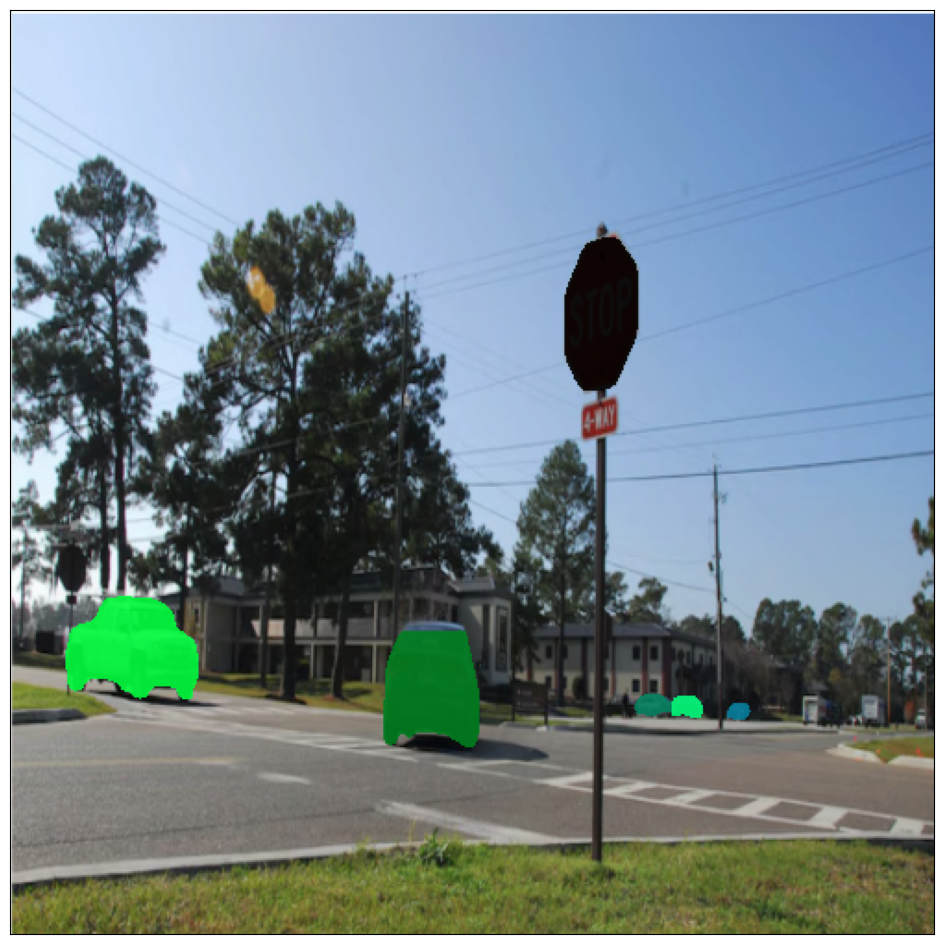

In [217]:
score_threshold = .8
output = filter_model_output(output=output,score_threshold=score_threshold)
output = get_boolean_mask(output)
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])